In [96]:
import matplotlib.pyplot as plt

from pynq import Overlay
import numpy as np

from qsystem_2 import *
from qsystem2_asm import *

In [103]:
soc = PfbSoc('qsystem_2.bit', force_init_clks=False)

In [104]:
with ASM_Program() as p:
    p.memri(0,1,0,"freq")
    p.memri(0,2,5,"gain")
    p.memri(0,3,2,"nsamp")
    p.regwi(0,4,0x9,"0b1001, stdysel = 1 (zero value), mode = 0 (nsamp), outsel = 01 (dds).")
    p.bitwi(0,4,4, "<<", 16)
    p.bitw(0,3,3,"|",4)
    p.regwi(0,5,0,"t")
    p.synci(1000)
    p.comment("Set readout frequency")
    p.memri(1,7,1) # Set the readout frequency
    p.seti(5,1,7,0)
    p.comment("Start")
    p.regwi(1,1,0x8001,"bit 15 = 1, bit 0 = 1")
    p.regwi(1,6,0xc001,"bit 15 = 1, bit 14 = 1, bit 0 = 1")
    p.regwi(1,7,100)
    p.seti(0,1,0,0) # test_tproc.asm has seti 0, 1, $0, 0
    p.comment("Loop")
    p.memri(1,2,3,"Nsync")
    p.memri(1,3,4,"Loop")
    p.label("LOOP")
    p.set(6,0,1,0,0,2,3,5)
    p.set(7,0,1,0,0,2,3,5)
    p.seti(0,1,6,0)
    p.seti(0,1,1,10)
    p.sync(1,2)
    p.loopnz(1,3,"LOOP")
    p.comment(" End")
    p.seti(0,1,0,0)
    p.end("all done")
soc.tproc.load_asm_program(p)

***Address Space***

<ol start="0">
    <li>Output Frequency (freq)</li>
    <li>DDS Readout Frequency </li>
    <li>Numer of Samples (nsamp)</li>
    <li>Sync Time (Nsync)</li>
    <li>Loop Iteration Count (Loop)</li>
    <li>Output Gain (gain)</li>
</ol>

Output Frequency DAC: 1600
DDS Frequency: 3200
nsamp: 150
nsync: 195
loop: 2
gain: 30000
Average Buffer Length: 150


RuntimeError: DMA channel not started

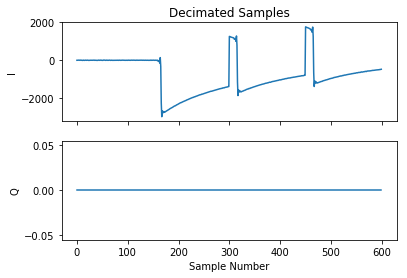

In [109]:
#Sends a pulse at the given frequency (freq) for the given time (nsamp) with the given gain (gain)
#and reads back a signal from the average buffer that is 1.3 times the duration (nsamp). 
#This is repeated (loop) times. 

debugMode = True
enablePrintBuffers = True
enablePrintAverages = True
enableTestFunction = True

def getAvgSamples (freq=150, gain=30000, nsamp=150, loop=3):
    
    #Set the address register space. 
    #Format the numbers and send them to the tproc for output frequency
    freqRegDAQ = freq2reg(soc.fs_dac, freq)
    soc.tproc.single_write(addr=0, data = freqRegDAQ)
    if debugMode: print(f"Output Frequency DAC: {freqRegDAQ}")
    #Format the nubmers and send them to the tproc for DDS frequency
    freqRegADC = freq2reg(soc.fs_adc, freq) #DDS is set to same freq as DAC
    soc.tproc.single_write(addr=1, data = freqRegADC)
    if debugMode: print(f"DDS Frequency: {freqRegADC}")
    #Simply write to the nsamp address WITHOUT formatting. (It is assumed that the user will do this)
    soc.tproc.single_write(addr=2, data = nsamp)
    if debugMode: print(f"nsamp: {nsamp}")
    #Write the size  of the pulse on the ADC domain (nSync). This is defined to be 1.3 times the duration (nsamp)
    nsync = int(nsamp * 1.3)
    soc.tproc.single_write(addr=3, data = nsync)
    if debugMode: print(f"nsync: {nsync}")
    #Write the loop iteration count (Loop). It should be noted that the loop iteration variable must be loopCount-1. 
    soc.tproc.single_write(addr=4, data = loop)
    if debugMode: print(f"loop: {loop - 1}")
    #Write output gain WITHOUT formatting to the output gain address. 
    soc.tproc.single_write(addr=5, data = gain)
    if debugMode: print(f"gain: {gain}")
    
    #Set the size of the average buffer to nsamp (number of decimated samples) and enable the buffer. 
    soc.readouts[0].set_out("input")
    soc.readouts[0].set_freq(freq)
    soc.avg_bufs[0].config(address = 0, length = nsamp)
    soc.avg_bufs[0].enable()
    if debugMode: print(f"Average Buffer Length: {nsamp}")
    
    #Start tProc
    #soc.setSelection("product")
    soc.tproc.stop()
    soc.tproc.start()
    
    if enablePrintBuffers:
        #Get I/Q decimated samples with the length loop * nsync where nsync is the number of decimated samples and 
        
        idec,qdec = soc.get_decimated(ch=0, length = (loop + 1) * nsamp)

        #Plot everything. 
        fig,ax = plt.subplots(2, 1, sharex=True)
        ax[0].plot(idec)
        ax[0].set_ylabel("I")
        ax[1].plot(qdec)
        ax[1].set_ylabel("Q")
        ax[1].set_xlabel("Sample Number")
        ax[0].set_title("Decimated Samples")
    
    #Get I/Q accumulated samples with the number of loop iterations. 
    iacc,qacc =  soc.get_accumulated(ch=0, length=loop)
    
    if enablePrintAverages: 
        #Get the absolute value of the I and Q values
        absValues = np.sqrt(iacc ** 2 + qacc ** 2)

        #Get the phase for each sample
        phases = np.arctan2(qacc, iacc)

        #Plot everything. 
        fig,ax = plt.subplots(4,1,sharex=True)
        ax[0].plot(iacc, "*-")
        ax[0].set_ylabel("I")
        ax[1].plot(qacc, "*-")
        ax[1].set_ylabel("Q")
        ax[2].plot(absValues, "*-")
        ax[2].set_ylabel("Abs Values")
        ax[3].set_xlabel("sample number")
        ax[3].plot(phases, "*-")
        ax[3].set_ylabel("Phases")
        ax[0].set_title("from getAccumulated")
    
    return iacc, qacc

if enableTestFunction: getAvgSamples()

Text(0.5,0,'Gain')

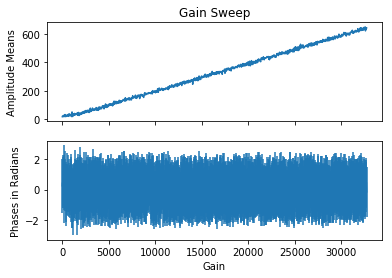

In [62]:
#Gain Sweep

gStart = 0
gStop = 32767
nGains = 1000

gains = np.linspace(gStart, gStop, nGains)
ampMeans = np.zeros(len(gains))
ampStds = np.zeros(len(gains))
phaseMeans = np.zeros(len(gains))
phaseStds = np.zeros(len(gains))

for i, g in enumerate(gains):
    iacc,qacc = getAvgSamples(gain=int(g))
    amps = np.abs(iacc + 1j * qacc)
    phases = np.angle(iacc + 1j * qacc)
    ampMeans[i] = amps[1:].mean()
    ampStds[i] = amps[1:].std()
    phaseMeans[i] = phases[1:].mean()
    phaseStds[i] = phases[1:].std()

fig,ax = plt.subplots(2,1,sharex=True)
plt.xkcd
ax[0].set_title("Gain Sweep")
#ax[0].errorbar(gains, ampMeans, yerr=ampStds)
ax[0].plot(gains, ampMeans)
ax[0].set_ylabel("Amplitude Means")
ax[1].errorbar(gains, phaseMeans, yerr=phaseStds)
ax[1].set_ylabel("Phases in Radians")
plt.xlabel("Gain")

[  17 -558 -180  605  455 -540 -688  343  783  -61] [ -13 -156 -629 -357  561  610 -420 -711  223  777]


Text(0.5,0,'MhZ')

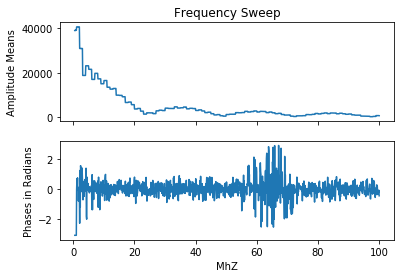

In [63]:
#Frequency Sweep

freqStart = 0.5 #MHz
freqStop = 100 #MHz
nFreqs = 1000
gain = 32767

freqs = np.linspace(freqStart, freqStop, nFreqs)
ampMeans = np.zeros(len(freqs))
ampStds = np.zeros(len(freqs))
phaseMeans = np.zeros(len(freqs))
phaseStds = np.zeros(len(freqs))

for i, f in enumerate(freqs):
    iacc,qacc = getAvgSamples(freq=int(f), gain=gain)
    amps = np.abs(iacc + 1j * qacc)
    phases = np.angle(iacc + 1j * qacc)
    ampMeans[i] = amps[1:].mean()
    ampStds[i] = amps[1:].std()
    phaseMeans[i] = phases[1:].mean()
    phaseStds[i] = phases[1:].std()

print(iacc, qacc)

fig,ax = plt.subplots(2,1,sharex=True)
ax[0].set_title("Frequency Sweep")
#ax[0].errorbar(freqs, ampMeans, yerr=ampStds)
ax[0].plot(freqs, ampMeans)
ax[0].set_ylabel("Amplitude Means")
#ax[1].errorbar(freqs, phaseMeans, yerr=phaseStds)
ax[1].plot(freqs, phaseMeans)
ax[1].set_ylabel("Phases in Radians")
plt.xlabel("MhZ")